In [29]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import seaborn as sns


In [30]:
# Load train & test sets
train_df = pd.read_csv("kdd_train.csv")
test_df  = pd.read_csv("kdd_test.csv")



train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [31]:
# Identify categorical and numerical columns BEFORE encoding
target_col = "labels"

categorical_cols = train_df.select_dtypes(include=['object']).columns.drop(target_col)
numeric_cols = train_df.columns.difference(categorical_cols.union([target_col]))


In [32]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])


In [33]:

# Base estimator for bagging (Decision Tree)
base_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,           
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced"
)


In [34]:
# Bagging Classifier
model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=150,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)


In [35]:
# Build full pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', model)
])

In [ ]:
# Train
pipeline.fit(train_df.drop('labels', axis=1), train_df['labels'])

# Predict
y_pred = pipeline.predict(test_df.drop('labels', axis=1))


#Evaluation Metrics
accuracy = accuracy_score(test_df['labels'], y_pred)
f1 = f1_score(test_df['labels'], y_pred, average='weighted')   # standard F1 weighted by support
recall = recall_score(test_df['labels'], y_pred, average='weighted')  # standard recall weighted by support
precision = precision_score(test_df['labels'], y_pred, average='weighted')  # standard precision weighted by support

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Accuracy: 0.9139
F1 Score: 0.8783
Recall: 0.9139
Precision: 0.8723


c:\Users\ishif\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


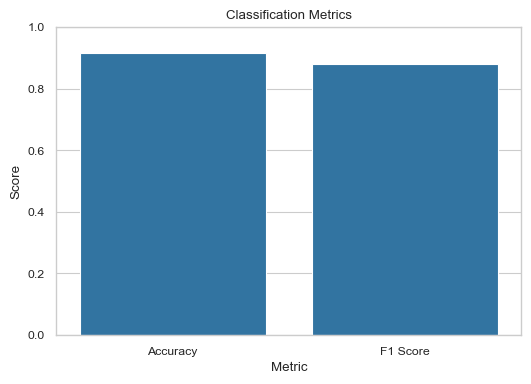

In [37]:
# Apply style
sns.set_style("whitegrid")
sns.set_context("paper")

# Compute metrics
accuracy = accuracy_score(test_df['labels'], y_pred)
f1 = f1_score(test_df['labels'], y_pred, average='weighted')   # weighted F1 for multiclass


# Prepare DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [accuracy, f1]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Classification Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
